# Seleção do Dataset

In [126]:
# Dataset retirado de https://raw.githubusercontent.com/adamlamee/CODINGinK12/master/data/stars.csv
# Filtragem de distâncias muito grandes realizadas, corrigindo os outliers de estrelas supergigantes

In [127]:
# ===================== HR + CLUSTER (DATASET CUSTOM) =====================

# Obtenção, Tratamento e Processamento dos Dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
from shapely.geometry import Polygon, MultiPolygon
import alphashape

# Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
import hdbscan

In [128]:
dataset_file = "stars.csv"

col_color = "ci"
col_mag = "absmag"
col_temp = "temp"
col_lum = "lum"
col_raio = "radius_est"

In [129]:
# ---------------- 2) LER DADOS ----------------
df = pd.read_csv(dataset_file)
print("Shape original:", df.shape)

Shape original: (119614, 16)


In [125]:
# ---------------- 3) LIMPEZA BÁSICA ----------------
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=[col_color, col_mag, col_temp, col_lum])

# Filtros físicos razoáveis
df = df[df[col_color].between(-0.5, 2.5)]
df = df[df[col_mag].between(-15, 20)]
df = df[df[col_temp].between(2000, 50000)]
df = df[df[col_lum] > 0]

print("Após limpeza:", df.shape)

Após limpeza: (117594, 16)


In [8]:
# ---------------- 4) ESTIMAR RAIO (opcional) ----------------
# R/Rsun = sqrt(L / (T/Tsun)^4)
Tsun = 5772
df["radius_est"] = np.sqrt(df[col_lum] / ((df[col_temp] / Tsun) ** 4))

# ---------------- 5) IDENTIFICAR POSSÍVEIS ANÃS BRANCAS ----------------
# Critério simples:
#   alta magnitude absoluta (>= 10)
#   cor azul (ci < 0.5)
df["white_dwarf_flag"] = (
    (df[col_mag] > 10) &
    (df[col_color] < 0.5)
)

In [9]:
df = df[df["dist"] < 5000] # Correção de distância, para evitar outliers absurdos
df = df.sample(50000, random_state=56)

In [ ]:
classes = [0, 3700, 5200, 6000, 7500, 10000, 30000, np.inf]
labels = ["M", "K", "G", "F", "A", "B", "O"]

df["classe_espectral"] = pd.cut(df[col_temp], bins=classes, labels=labels, right=False)

# Clustering

## Configurações Iniciais

In [10]:
variaveis = df[[col_mag, col_temp]]
scaler = StandardScaler()
variaveis_s = scaler.fit_transform(variaveis)

## Funções Auxiliares

In [11]:
def plot_cluster (dados_x, dados_y, clusters, metodo):

    plt.figure(figsize=(8, 6))

    # Plot dos dados originais coloridos com base no cluster a que pertencem
    for c in np.unique(clusters):
        mask = clusters == c
        plt.scatter(dados_x[mask], dados_y[mask],
                    s=2, alpha=1,
                    label=f"Cluster {c}")

    # Ajustes gerais do plot

    plt.gca().invert_yaxis() # Inverter eixo y
    plt.gca().invert_xaxis() # Inverter eixo x

    plt.xscale("log") # Eixo x na escala log para melhor visualização

    plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
    plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

    plt.title(f"Diagrama HR com Clustering por {metodo}")
    plt.legend(markerscale=1, fontsize="small", loc="best")

    plt.show()

    return

### K-Means

In [12]:
def encontrar_k (dados, k_max): # k_max: maior k a ser incluído na visualização

    k_elbow = [] # valores de k para cada valor de inércia correspondente
    k_silhouettes = [] # valores de k para cada silhouette score correspondente
    inertias = [] # valores encontrados para a inércia
    silhouettes = [] # valores encontrados para os silhouette scores

    # Gera silhouette scores e valores de inércia para k de 1 (inércia) ou 2 (silhouette) a k_max
    for k in range (1, k_max + 1): 
        kmeans = KMeans(n_clusters=k, random_state=56) # inicialização da instância de KMeans
        kmeans.fit(dados) # aplicação do processo ao conjunto de dados
        
        k_elbow.append(k) # armazenamento do valor de k atual
        inertias.append(kmeans.inertia_) # cálculo e armazenamento do valor de inércia para o k atual

        if k != 1: # Silhouette Scores só são válidos para k > 1
            score = silhouette_score(dados, kmeans.labels_) # cálculo do silhouette score
            silhouettes.append(score) # armazenamento do silhouette score
            k_silhouettes.append(k) # armazenamento do valor de k atual


    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) # criação da figura e dos dois subplots

    # Gráfico do elbow method
    axs[0].plot(k_elbow, inertias, marker="o", linestyle="-")
    axs[0].set_title("Elbow Method")
    axs[0].set_ylabel("Inertia")
    axs[0].set_xlabel("k")

    # Gráfico de silhouette score
    axs[1].plot(k_silhouettes, silhouettes, marker="o", linestyle="-")
    axs[1].set_title("Silhouette Score")
    axs[1].set_ylabel("Score")
    axs[1].set_xlabel("k")

    plt.tight_layout() # reajuste dos subplots para melhor organização dos gráficos
    plt.show() # exibição do gráfico

    return

In [13]:
def plot_k_means (dados_x, dados_y, clusters, kmeans, scaler):

    # Obtenção dos centroides na escala original
    centroides_iniciais = kmeans.cluster_centers_ # centroides na escala padronizada
    centroides = scaler.inverse_transform(centroides_iniciais) # centroides na escala original

    # Plot dos dados originais coloridos com base no cluster a que pertencem
    cores = cm.get_cmap("tab10", kmeans.n_clusters)

    for c in np.unique(clusters):
        mask = clusters == c
        plt.scatter(dados_x[mask], dados_y[mask],
                    s=2,
                    alpha=0.3,
                    color=cores(c),
                    label=f"Cluster {c}")

        # centróide do cluster c
        plt.scatter(centroides[c,1], centroides[c,0],
                    marker="X",
                    s=120,
                    color=cores(c),
                    edgecolor="black")

    # Ajustes gerais do plot

    plt.gca().invert_yaxis() # Inverter eixo y
    plt.gca().invert_xaxis() # Inverter eixo x

    plt.xscale("log") # Eixo x na escala log para melhor visualização

    plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
    plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

    plt.title("Diagrama HR com Clusterização por K-Means")
    plt.legend(markerscale=1, fontsize="small", loc="best")

    plt.show()

    return

In [14]:
def visualizar_k (dados_s, dados_x, dados_y, k_min, k_max):

    divisoes = [] # Lista que armazena as classificações para diferentes valores de k

    for k in range(k_min, k_max + 1): # Clustering para k de k_min a k_max

        kmeans = KMeans(n_clusters=k, random_state=42) # criação da instância de KMeans
        kmeans.fit(dados_s) # aplicação do K-Means aos dados
        divisao = kmeans.labels_ # obtenção das classificações dos dados
        divisoes.append(divisao) # armazenamento das classificações
    
    # Plot da figura com os diferentes gráficos distribuídos horizontalmente e com tamanhos iguais
    fig, axs = plt.subplots(nrows=1, ncols=k_max - k_min + 1, figsize=(5*k_max, 5))

    for i, ax in enumerate(fig.axes, start=1):

        # Plot individual dos gráficos para cada valor de k
        ax.scatter(x=dados_x, y=dados_y, c=divisoes[i - 1], s=2)
        ax.set_title(f"Clustering k = {k_min - 1 + i}")
        ax.set_xscale("log")
        ax.set_xlabel("Temperatura (K)")
        ax.set_ylabel("Magnitude Absoluta")

        ax.invert_xaxis()
        ax.invert_yaxis()


    plt.show()
        
    return

### Hierárquico

In [15]:
def dendrograma_ward (dados):

    plt.title("Dendrograma (Ward)") # título

    # Criação do dendrograma com base no método 'ward'
    dendrograma = sch.dendrogram(sch.linkage(dados, method="ward"), no_labels=True) # esconde os rótulos

    return

In [16]:
def dendrograma_simple (dados):

    plt.title("Dendrograma (Ward)") # título

    # Criação do dendrograma com base no método 'ward'
    dendrograma = sch.dendrogram(sch.linkage(dados, method="single"), no_labels=True) # esconde os rótulos

    return

In [17]:
def encontrar_n_ward (dados, n_max):

    n_silhouettes = [] # guarda cada número n de clusters testado
    silhouettes = [] # guarda os Silhouette Scores

    for n in range (2, n_max + 1):

        # Aplica o Agglomerative Clustering aos dados usando 'ward'
        h_cluster = AgglomerativeClustering(n_clusters=n, linkage="ward")
        h_cluster.fit(dados)

        # Armazena o n e o seu respectivo Silhouette Score
        score = silhouette_score(dados, h_cluster.labels_)
        silhouettes.append(score)
        n_silhouettes.append(n)

    # Plota o gráfico dos Silhouette Scores
    plt.plot(n_silhouettes, silhouettes, marker="o", linestyle="-")
    plt.title("Silhouette Score")
    plt.ylabel("Score")
    plt.xlabel("n")
    plt.show()
    
    return

In [18]:
def encontrar_n_simple (dados, n_max):

    n_silhouettes = [] # guarda cada número n de clusters testado
    silhouettes = [] # guarda os Silhouette Scores

    for n in range (2, n_max + 1):

        # Aplica o Agglomerative Clustering aos dados usando 'single linkage'
        h_cluster = AgglomerativeClustering(n_clusters=n, linkage="single")
        h_cluster.fit(dados)

        # Armazena o n e o seu respectivo Silhouette Score
        score = silhouette_score(dados, h_cluster.labels_)
        silhouettes.append(score)
        n_silhouettes.append(n)

    # Plota o gráfico dos Silhouette Scores
    plt.plot(n_silhouettes, silhouettes, marker="o", linestyle="-")
    plt.title("Silhouette Score")
    plt.ylabel("Score")
    plt.xlabel("n")
    plt.show()
    
    return

## K-Means

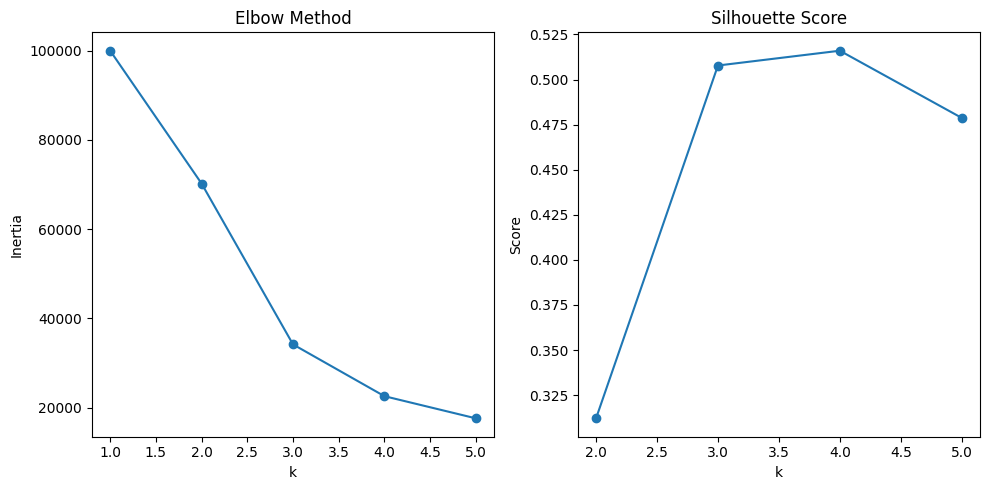

In [19]:
encontrar_k(variaveis_s, 5)

C:\Users\marce\AppData\Local\Temp\ipykernel_14296\3144574037.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cores = cm.get_cmap("tab10", kmeans.n_clusters)


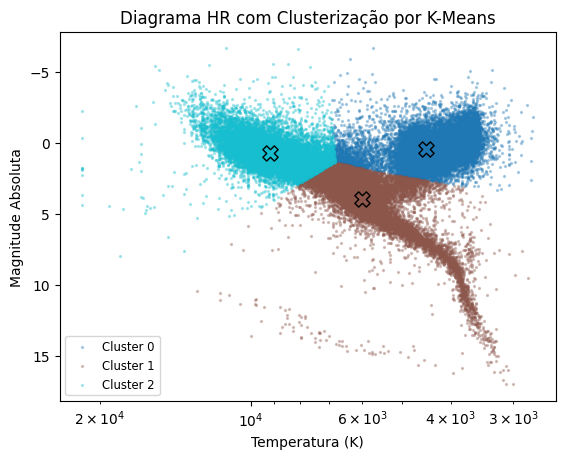

In [20]:
kmeans_3 = KMeans(n_clusters=3, random_state=50) # geração da instância de KMeans referente a k = 3
kmeans_3.fit(variaveis_s) # aplicação da instância aos dados padronizados
df["k3"] = kmeans_3.labels_ # obtenção das classificações de cada ponto

plot_k_means (df[col_temp], df[col_mag], df["k3"], kmeans_3, scaler)

C:\Users\marce\AppData\Local\Temp\ipykernel_14296\3144574037.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cores = cm.get_cmap("tab10", kmeans.n_clusters)


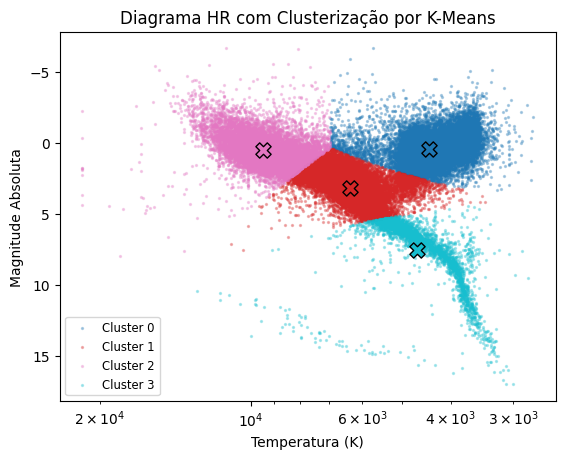

In [21]:
kmeans_4 = KMeans(n_clusters=4, random_state=50) # geração da instância de KMeans referente a k = 4
kmeans_4.fit(variaveis_s) # aplicação da instância aos dados padronizados
df["k4"] = kmeans_4.labels_ # obtenção das classificações de cada ponto

plot_k_means (df[col_temp], df[col_mag], df["k4"], kmeans_4, scaler)

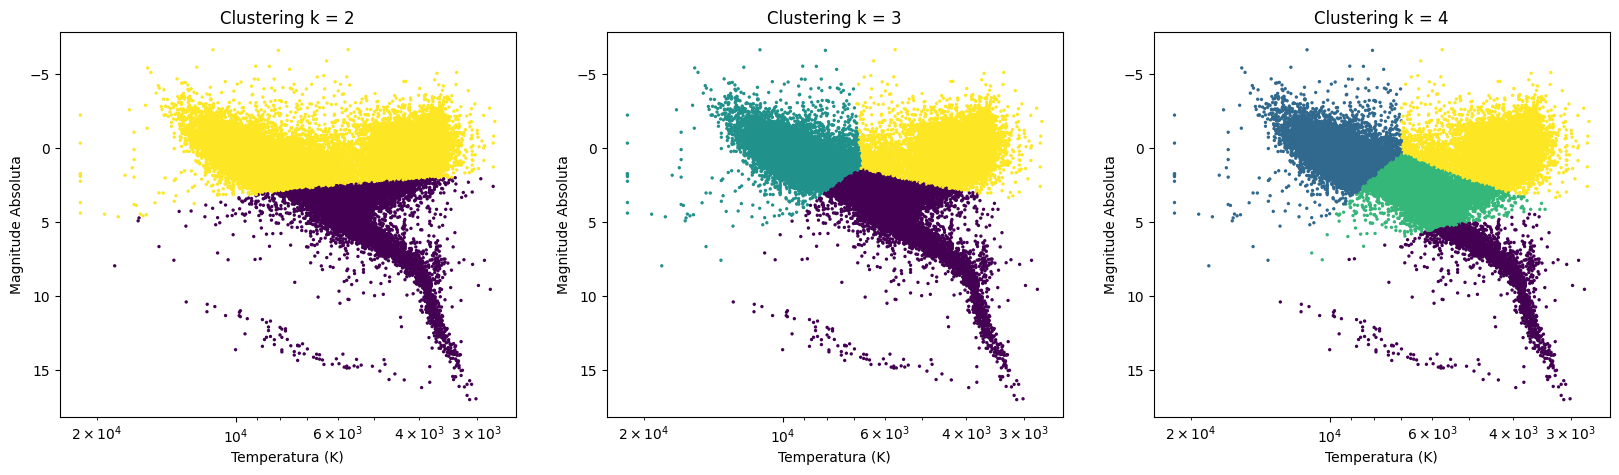

In [22]:
visualizar_k (variaveis_s, df[col_temp], df[col_mag], 2, 4)

## DBSCAN

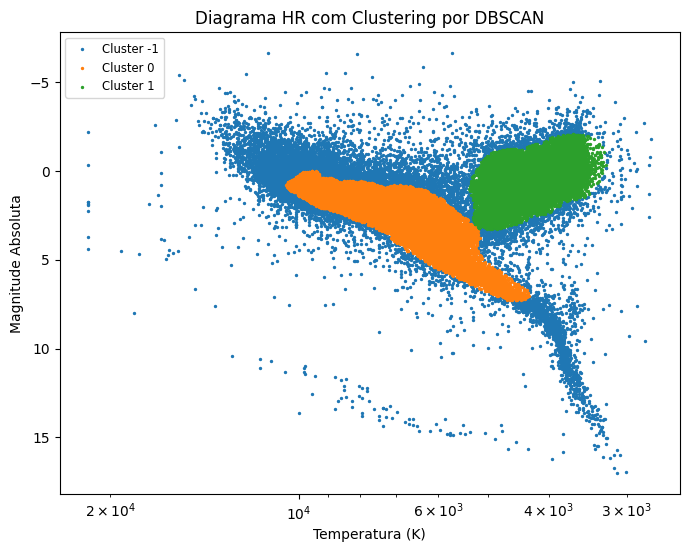

In [23]:
dbscan_modelo = DBSCAN(eps=0.1, min_samples=133).fit(variaveis_s) # criação do modelo para cada combinação
dbscan_labels = dbscan_modelo.labels_ # obtenção da classificação dos dados para cada modelo

df["dbscan_10"] = dbscan_labels # armazenamento das classificações

plot_cluster (df[col_temp], df[col_mag], df["dbscan_10"], "DBSCAN")

## GMM

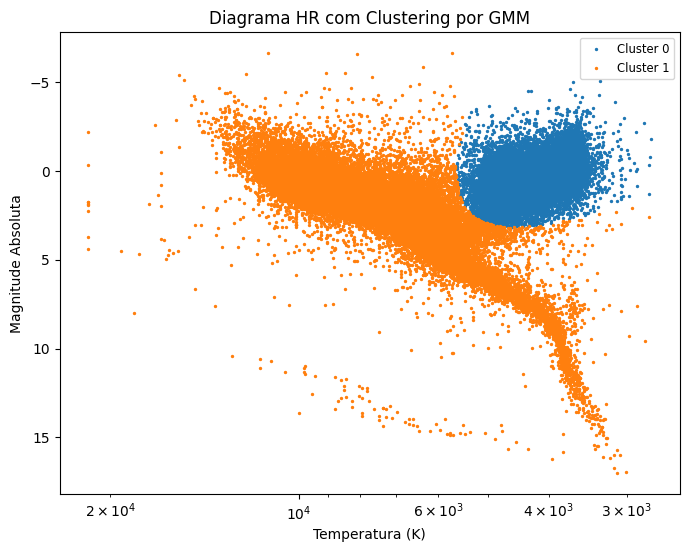

In [24]:
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=50)
gmm_labels = gmm.fit_predict(variaveis_s)

df["gmm_2"] = gmm_labels
plot_cluster (df[col_temp], df[col_mag], df["gmm_2"], "GMM")


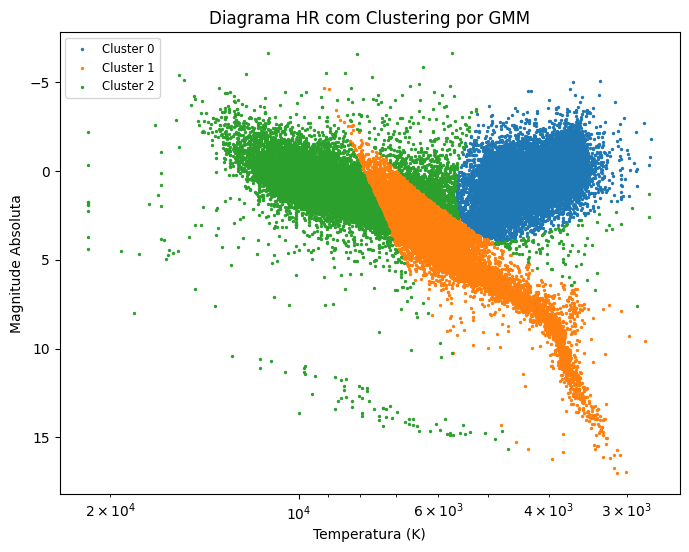

In [25]:
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=50)
gmm_labels = gmm.fit_predict(variaveis_s)

df["gmm_3"] = gmm_labels
plot_cluster (df[col_temp], df[col_mag], df["gmm_3"], "GMM")

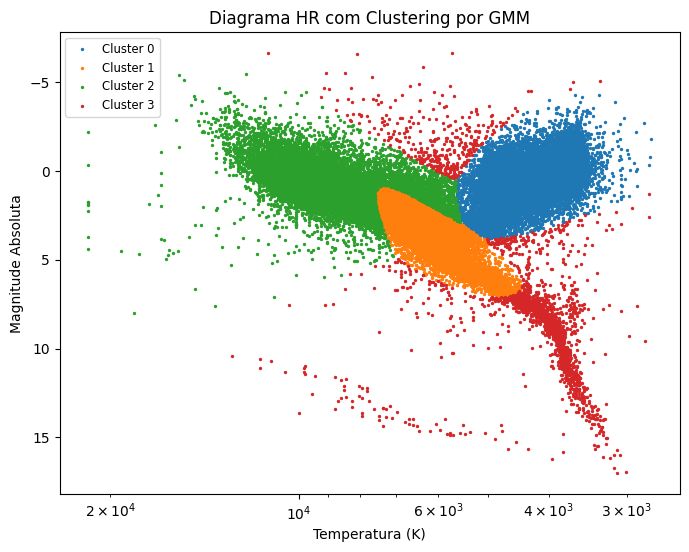

In [26]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=50)
gmm_labels = gmm.fit_predict(variaveis_s)

df["gmm_4"] = gmm_labels
plot_cluster (df[col_temp], df[col_mag], df["gmm_4"], "GMM")

## HDBSCAN

In [27]:
min_cluster_size = 1000

cluster_hdbscan = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
df["hdbscan"] = cluster_hdbscan.fit_predict(variaveis_s)

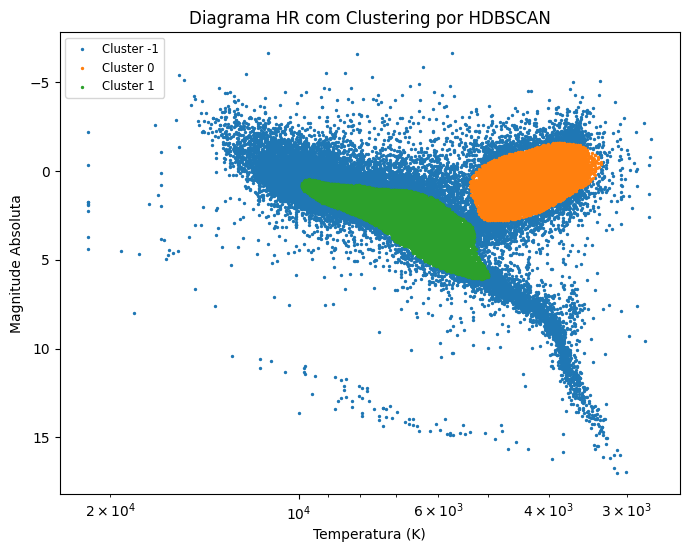

In [28]:
plot_cluster (df[col_temp], df[col_mag], df["hdbscan"], "HDBSCAN")


## Conclusões

# Construção do Gráfico

In [61]:
dfp = df.sample(10000, random_state=56)

## Extra

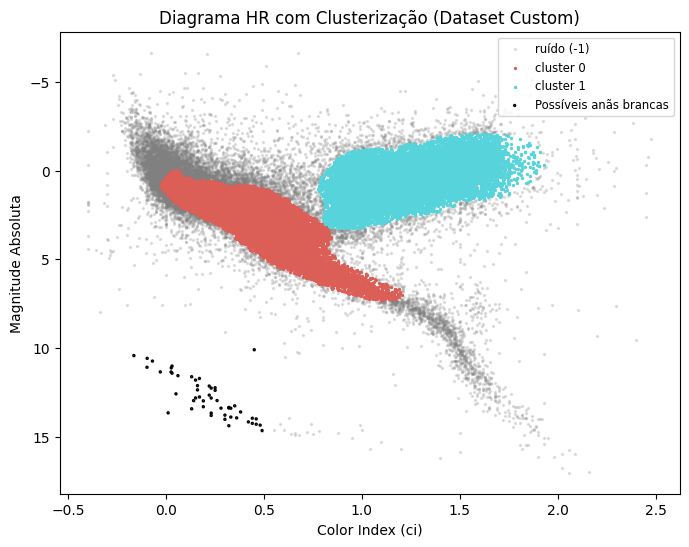

In [29]:
plt.figure(figsize=(8, 6))

# Separar clusters
clusters_valid = [c for c in df["dbscan_10"].unique() if c != -1]

palette = sns.color_palette("hls", len(clusters_valid))
cluster_colors = {c: palette[i] for i, c in enumerate(clusters_valid)}
cluster_colors[-1] = (0.5, 0.5, 0.5)

# Plot ruído transparente
noise = df[df["dbscan_10"] == -1]
plt.scatter(noise[col_color], noise[col_mag],
            c=[cluster_colors[-1]],
            alpha=0.2, s=2, label="ruído (-1)")

# Plot clusters válidos
for c in clusters_valid:
    subset = df[df["dbscan_10"] == c]
    plt.scatter(subset[col_color], subset[col_mag],
                c=[cluster_colors[c]],
                s=2, alpha=1, label=f"cluster {c}")

# Destacar anãs brancas
wd = df[df["white_dwarf_flag"]]
plt.scatter(wd[col_color], wd[col_mag],
            edgecolors="black",
            facecolors="none",
            s=2,
            label="Possíveis anãs brancas")

plt.gca().invert_yaxis()
plt.xlabel("Color Index (ci)")
plt.ylabel("Magnitude Absoluta")
plt.title("Diagrama HR com Clusterização (Dataset Custom)")
plt.legend(markerscale=1, fontsize="small", loc="best")
plt.show()

## DBSCAN

### Gráfico 01 - Tamanho dependente do Raio

In [134]:
r = dfp[col_raio]

# corta outliers
r_clip = r.clip(r.quantile(0.05), r.quantile(0.95))

# normaliza tamanho
s_min, s_max = 5, 60
s = s_min + (r_clip - r_clip.min())/(r_clip.max() - r_clip.min()) * (s_max - s_min)

In [135]:
cores = {
    -1: "gray",     # ruído
     0: "blue",
     1: "red",
}

c = dfp["dbscan_10"].map(cores)

C:\Users\marce\AppData\Local\Temp\ipykernel_14296\3296475971.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(markerscale=1, fontsize="small", loc="best")


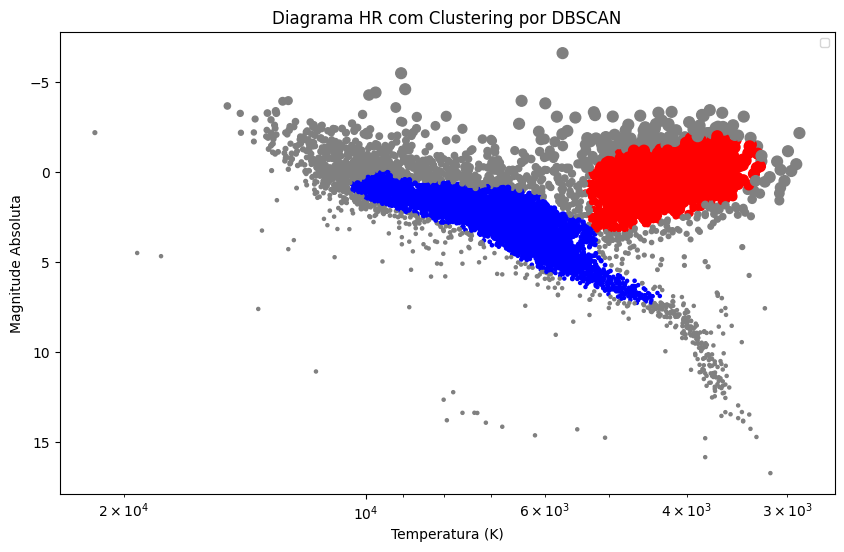

In [143]:
plt.style.use("default")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=c)

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log") # Eixo x na escala log para melhor visualização

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

plt.title(f"Diagrama HR com Clustering por DBSCAN")
plt.legend(markerscale=1, fontsize="small", loc="best")

plt.show()

### Gráfico 02 - Adição de Contornos

In [137]:
def desenhar_elipse(x, y, ax, n_std=3.5, **kwargs):
    cov = np.cov(x, y)
    mean_x, mean_y = np.mean(x), np.mean(y)

    # autovalores e autovetores
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    # ângulo da elipse
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # largura e altura (raiz dos autovalores)
    width, height = 2 * n_std * np.sqrt(vals)

    ellipse = Ellipse((mean_x, mean_y),
                      width=width, height=height,
                      angle=theta,
                      fill=False,
                      **kwargs)

    ax.add_patch(ellipse)

C:\Users\marce\AppData\Local\Temp\ipykernel_14296\2294714269.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(markerscale=1, fontsize="small", loc="best")


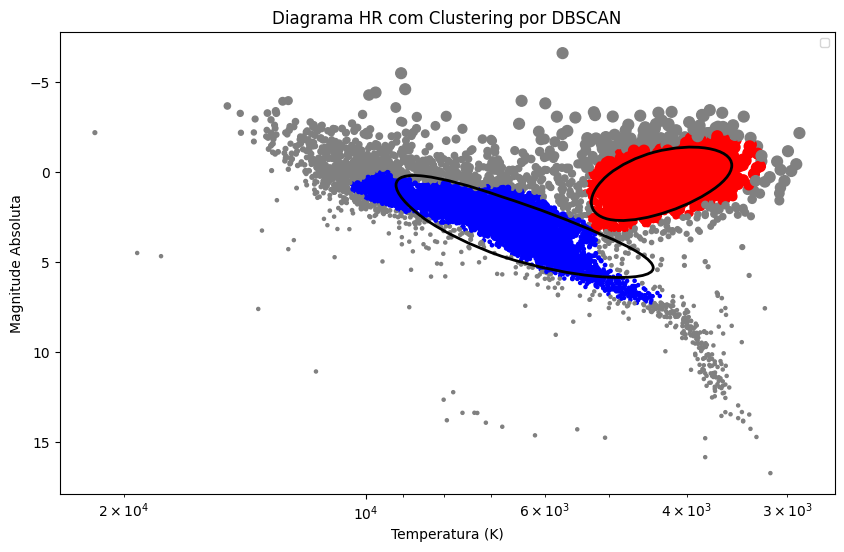

In [144]:
plt.style.use("default")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=c)

for cl in sorted(dfp["dbscan_10"].unique()):
    if cl == -1:
        continue  # ignora ruído

    subset = dfp[dfp["dbscan_10"] == cl]

    desenhar_elipse(subset[col_temp], subset[col_mag], ax,
                    n_std=2.0, edgecolor="black", linewidth=2)

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log") # Eixo x na escala log para melhor visualização

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

plt.title(f"Diagrama HR com Clustering por DBSCAN")
plt.legend(markerscale=1, fontsize="small", loc="best")

plt.show()

C:\Users\marce\AppData\Local\Temp\ipykernel_14296\866399218.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(markerscale=1, fontsize="small", loc="best")


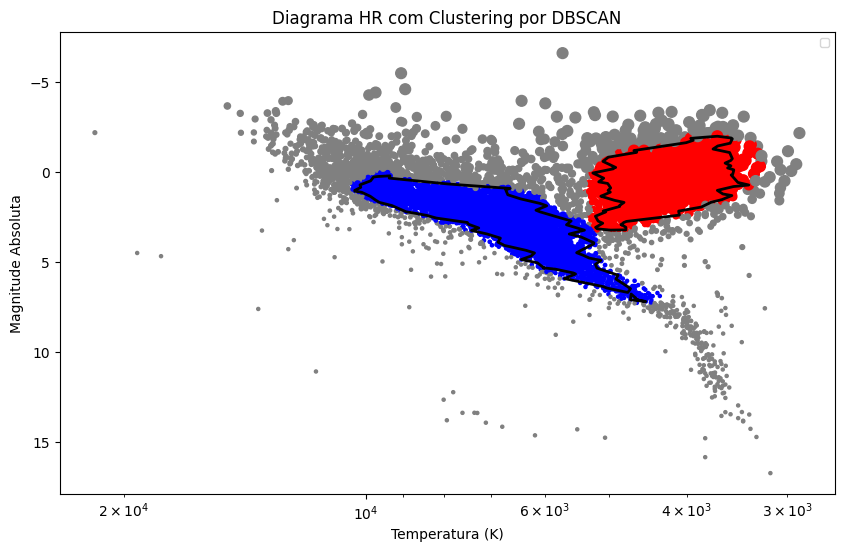

In [145]:
plt.style.use("default")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=c)

for cl in sorted(dfp["dbscan_10"].unique()):
    if cl == -1:
        continue

    subset = dfp[dfp["dbscan_10"] == cl]

    if len(subset) > 600:
        subset = subset.sample(600, random_state=0)

    x = np.log10(subset[col_temp].values)
    y = subset[col_mag].values

    pontos = list(zip(x, y))

    alpha = 1.0
    shape = alphashape.alphashape(pontos, alpha)

    if isinstance(shape, Polygon):
        xs, ys = shape.exterior.xy
        ax.plot(10**np.array(xs), ys, color="black", linewidth=2)

    elif isinstance(shape, MultiPolygon):
        for geom in shape.geoms:
            xs, ys = geom.exterior.xy
            ax.plot(10**np.array(xs), ys, color="black", linewidth=2)

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log") # Eixo x na escala log para melhor visualização

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

plt.title(f"Diagrama HR com Clustering por DBSCAN")
plt.legend(markerscale=1, fontsize="small", loc="best")

plt.show()

### Gráfico 03 - Classes Espectrais

In [140]:
cores_espectrais = {
    "O": "#4f6cff",
    "B": "#7ea8ff",
    "A": "#dbe9ff",   # branco azulado mais visível
    "F": "#fff7d6",   # branco levemente amarelado
    "G": "#ffe86b",
    "K": "#ffb347",
    "M": "#ff5c5c"
}

dfp["cor_espectral"] = dfp["classe_espectral"].map(cores_espectrais)

C:\Users\marce\AppData\Local\Temp\ipykernel_14296\3610442974.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(markerscale=1, fontsize="small", loc="best")


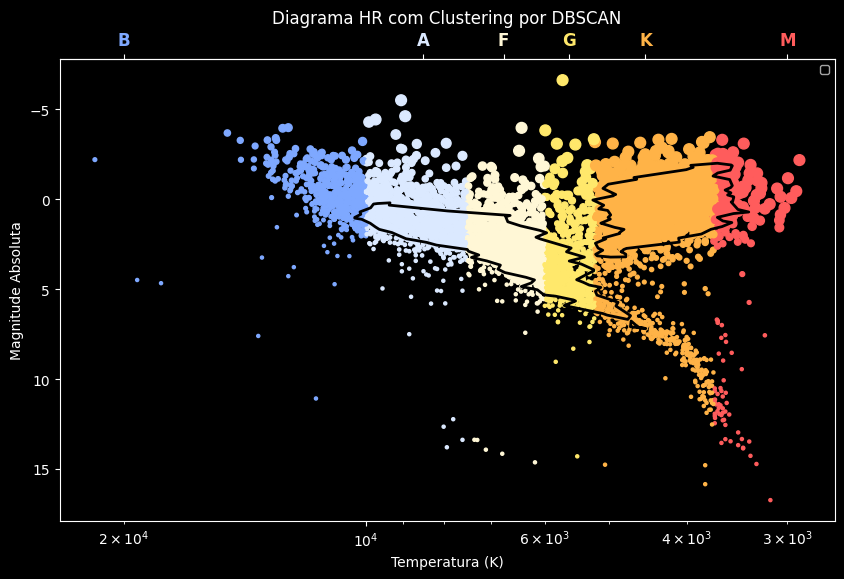

In [147]:
plt.style.use("dark_background")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=dfp["cor_espectral"])

for cl in sorted(dfp["dbscan_10"].unique()):
    if cl == -1:
        continue

    subset = dfp[dfp["dbscan_10"] == cl]

    if len(subset) > 600:
        subset = subset.sample(600, random_state=0)

    x = np.log10(subset[col_temp].values)
    y = subset[col_mag].values

    pontos = list(zip(x, y))

    alpha = 1.0
    shape = alphashape.alphashape(pontos, alpha)

    if isinstance(shape, Polygon):
        xs, ys = shape.exterior.xy
        ax.plot(10**np.array(xs), ys, color="black", linewidth=2)

    elif isinstance(shape, MultiPolygon):
        for geom in shape.geoms:
            xs, ys = geom.exterior.xy
            ax.plot(10**np.array(xs), ys, color="black", linewidth=2)

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log") # Eixo x na escala log para melhor visualização

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

# eixo superior
ax_top = ax.secondary_xaxis('top')

ticks_temp = [40000, 20000, 8500, 6750, 5600, 4500, 3000]
labels = ["O", "B", "A", "F", "G", "K", "M"]

ax_top.set_xticks(ticks_temp)
ax_top.set_xticklabels(labels)

# colorir os rótulos
for tick, label in zip(ax_top.get_xticklabels(), labels):
    tick.set_color(cores_espectrais[label])
    tick.set_fontsize(12)
    tick.set_fontweight("bold")

ax_top.tick_params(which='minor', top=False)
ax_top.minorticks_off()

plt.title(f"Diagrama HR com Clustering por DBSCAN")
plt.legend(markerscale=1, fontsize="small", loc="best")

plt.show()

### Gráfico 04 - Retas com Raios

C:\Users\marce\AppData\Local\Temp\ipykernel_14296\2048136960.py:88: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(markerscale=1, fontsize="small", loc="best")


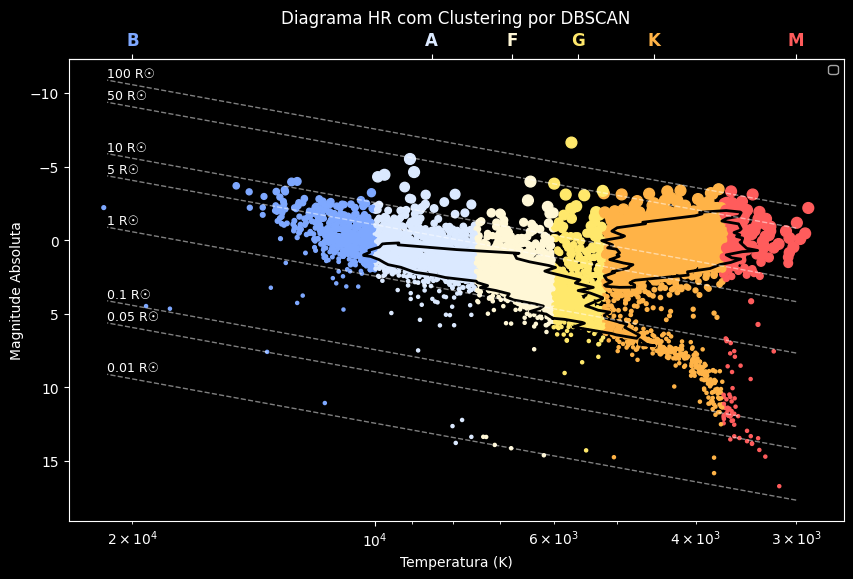

In [155]:
plt.style.use("dark_background")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=dfp["cor_espectral"])

for cl in sorted(dfp["dbscan_10"].unique()):
    if cl == -1:
        continue

    subset = dfp[dfp["dbscan_10"] == cl]

    if len(subset) > 600:
        subset = subset.sample(600, random_state=0)

    x = np.log10(subset[col_temp].values)
    y = subset[col_mag].values

    pontos = list(zip(x, y))

    alpha = 1.0
    shape = alphashape.alphashape(pontos, alpha)

    if isinstance(shape, Polygon):
        xs, ys = shape.exterior.xy
        ax.plot(10**np.array(xs), ys, color="black", linewidth=2)

    elif isinstance(shape, MultiPolygon):
        for geom in shape.geoms:
            xs, ys = geom.exterior.xy
            ax.plot(10**np.array(xs), ys, color="black", linewidth=2)

T_sun = 5777
M_sun = 4.83

# intervalo de temperatura do seu gráfico
T_vals = np.logspace(np.log10(3000), np.log10(21500), 500)

raios = [0.01, 0.05, 0.1, 1, 5, 10, 50, 100]

for R in raios:
    M_vals = (
        M_sun
        - 5*np.log10(R)
        - 10*np.log10(T_vals / T_sun)
    )

    ax.plot(T_vals, M_vals, linestyle="--", linewidth=1, color="white", alpha=0.5)

    # rótulo perto da borda direita
    ax.text(
        T_vals[-1],
        M_vals[-1],
        f"{R} R☉",
        fontsize=9,
        verticalalignment='bottom'
    )

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log") # Eixo x na escala log para melhor visualização

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

# eixo superior
ax_top = ax.secondary_xaxis('top')

ticks_temp = [40000, 20000, 8500, 6750, 5600, 4500, 3000]
labels = ["O", "B", "A", "F", "G", "K", "M"]

ax_top.set_xticks(ticks_temp)
ax_top.set_xticklabels(labels)

# colorir os rótulos
for tick, label in zip(ax_top.get_xticklabels(), labels):
    tick.set_color(cores_espectrais[label])
    tick.set_fontsize(12)
    tick.set_fontweight("bold")

ax_top.tick_params(which='minor', top=False)
ax_top.minorticks_off()

plt.title(f"Diagrama HR com Clustering por DBSCAN")
plt.legend(markerscale=1, fontsize="small", loc="best")

plt.show()

## GMM

### Gráfico 01 - Tamanho dependente do Raio

In [157]:
cores = {
     0: "blue",
     1: "red",
}

c = dfp["gmm_2"].map(cores)

C:\Users\marce\AppData\Local\Temp\ipykernel_14296\3642765377.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(markerscale=1, fontsize="small", loc="best")


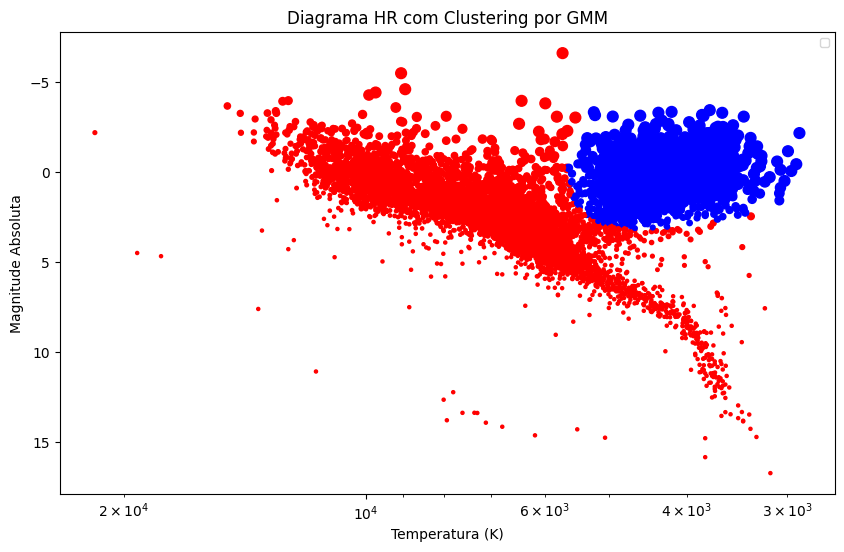

In [159]:
plt.style.use("default")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=c)

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log") # Eixo x na escala log para melhor visualização

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

plt.title(f"Diagrama HR com Clustering por GMM")
plt.legend(markerscale=1, fontsize="small", loc="best")

plt.show()

### Gráfico 02 - Adição de Contornos

C:\Users\marce\AppData\Local\Temp\ipykernel_14296\4235421771.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(markerscale=1, fontsize="small", loc="best")


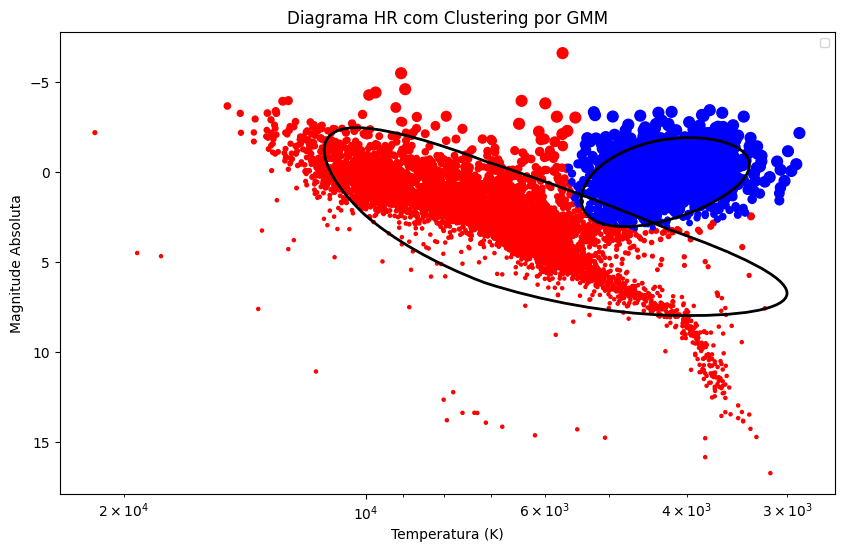

In [174]:
plt.style.use("default")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=c)

for cl in sorted(dfp["gmm_2"].unique()):

    subset = dfp[dfp["gmm_2"] == cl]

    desenhar_elipse(subset[col_temp], subset[col_mag], ax,
                    n_std=2.25, edgecolor="black", linewidth=2)

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log") # Eixo x na escala log para melhor visualização

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

plt.title(f"Diagrama HR com Clustering por GMM")
plt.legend(markerscale=1, fontsize="small", loc="best")

plt.show()

### Gráfico 03 - Classes Espectrais

C:\Users\marce\AppData\Local\Temp\ipykernel_14296\3320708581.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(markerscale=1, fontsize="small", loc="best")


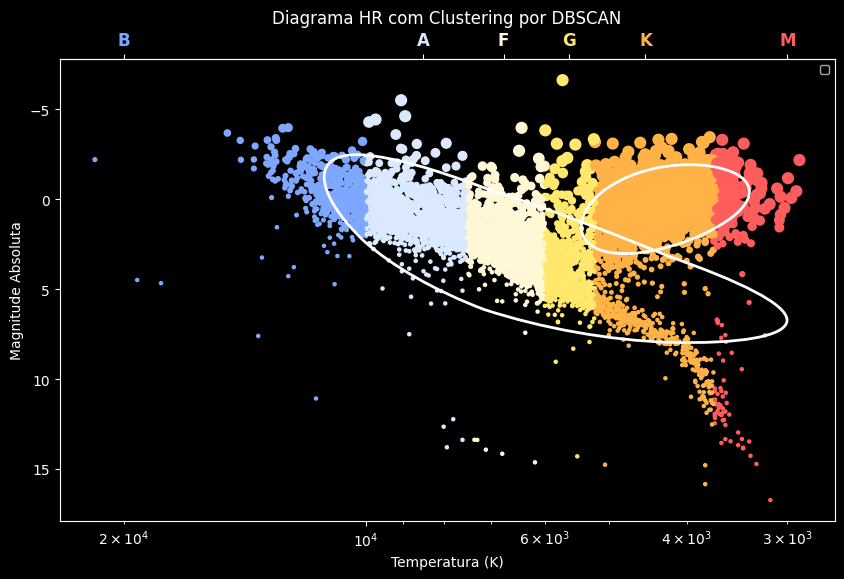

In [179]:
plt.style.use("dark_background")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=dfp["cor_espectral"])

for cl in sorted(dfp["gmm_2"].unique()):

    subset = dfp[dfp["gmm_2"] == cl]

    desenhar_elipse(subset[col_temp], subset[col_mag], ax,
                    n_std=2.25, edgecolor="white", linewidth=2)

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log") # Eixo x na escala log para melhor visualização

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

# eixo superior
ax_top = ax.secondary_xaxis('top')

ticks_temp = [40000, 20000, 8500, 6750, 5600, 4500, 3000]
labels = ["O", "B", "A", "F", "G", "K", "M"]

ax_top.set_xticks(ticks_temp)
ax_top.set_xticklabels(labels)

# colorir os rótulos
for tick, label in zip(ax_top.get_xticklabels(), labels):
    tick.set_color(cores_espectrais[label])
    tick.set_fontsize(12)
    tick.set_fontweight("bold")

ax_top.tick_params(which='minor', top=False)
ax_top.minorticks_off()

plt.title(f"Diagrama HR com Clustering por DBSCAN")
plt.legend(markerscale=1, fontsize="small", loc="best")

plt.show()

### Gráfico 04 - Retas com Raios

C:\Users\marce\AppData\Local\Temp\ipykernel_14296\1987067786.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(markerscale=1, fontsize="small", loc="best")


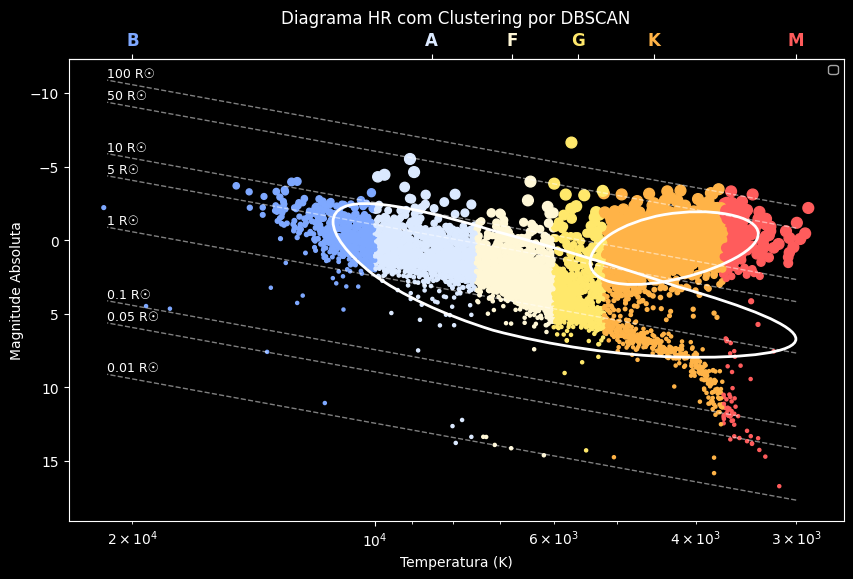

In [180]:
plt.style.use("dark_background")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=dfp["cor_espectral"])

for cl in sorted(dfp["gmm_2"].unique()):

    subset = dfp[dfp["gmm_2"] == cl]

    desenhar_elipse(subset[col_temp], subset[col_mag], ax,
                    n_std=2.25, edgecolor="white", linewidth=2)

T_sun = 5777
M_sun = 4.83

# intervalo de temperatura do seu gráfico
T_vals = np.logspace(np.log10(3000), np.log10(21500), 500)

raios = [0.01, 0.05, 0.1, 1, 5, 10, 50, 100]

for R in raios:
    M_vals = (
        M_sun
        - 5*np.log10(R)
        - 10*np.log10(T_vals / T_sun)
    )

    ax.plot(T_vals, M_vals, linestyle="--", linewidth=1, color="white", alpha=0.5)

    # rótulo perto da borda direita
    ax.text(
        T_vals[-1],
        M_vals[-1],
        f"{R} R☉",
        fontsize=9,
        verticalalignment='bottom'
    )

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log") # Eixo x na escala log para melhor visualização

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

# eixo superior
ax_top = ax.secondary_xaxis('top')

ticks_temp = [40000, 20000, 8500, 6750, 5600, 4500, 3000]
labels = ["O", "B", "A", "F", "G", "K", "M"]

ax_top.set_xticks(ticks_temp)
ax_top.set_xticklabels(labels)

# colorir os rótulos
for tick, label in zip(ax_top.get_xticklabels(), labels):
    tick.set_color(cores_espectrais[label])
    tick.set_fontsize(12)
    tick.set_fontweight("bold")

ax_top.tick_params(which='minor', top=False)
ax_top.minorticks_off()

plt.title(f"Diagrama HR com Clustering por DBSCAN")
plt.legend(markerscale=1, fontsize="small", loc="best")

plt.show()

## Classes Espectrais

C:\Users\marce\AppData\Local\Temp\ipykernel_14296\306654911.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(markerscale=1, fontsize="small", loc="best")


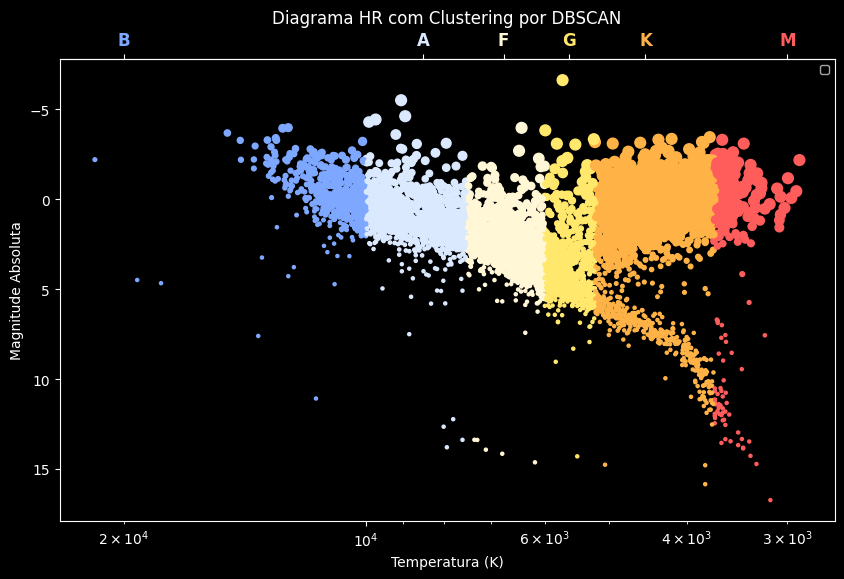

In [153]:
plt.style.use("dark_background")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=dfp["cor_espectral"])

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log") # Eixo x na escala log para melhor visualização

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

# eixo superior
ax_top = ax.secondary_xaxis('top')

ticks_temp = [40000, 20000, 8500, 6750, 5600, 4500, 3000]
labels = ["O", "B", "A", "F", "G", "K", "M"]

ax_top.set_xticks(ticks_temp)
ax_top.set_xticklabels(labels)

# colorir os rótulos
for tick, label in zip(ax_top.get_xticklabels(), labels):
    tick.set_color(cores_espectrais[label])
    tick.set_fontsize(12)
    tick.set_fontweight("bold")

ax_top.tick_params(which='minor', top=False)
ax_top.minorticks_off()

plt.title(f"Diagrama HR com Clustering por DBSCAN")
plt.legend(markerscale=1, fontsize="small", loc="best")

plt.show()

### Retas com Raios

C:\Users\marce\AppData\Local\Temp\ipykernel_14296\576562271.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(markerscale=1, fontsize="small", loc="best")


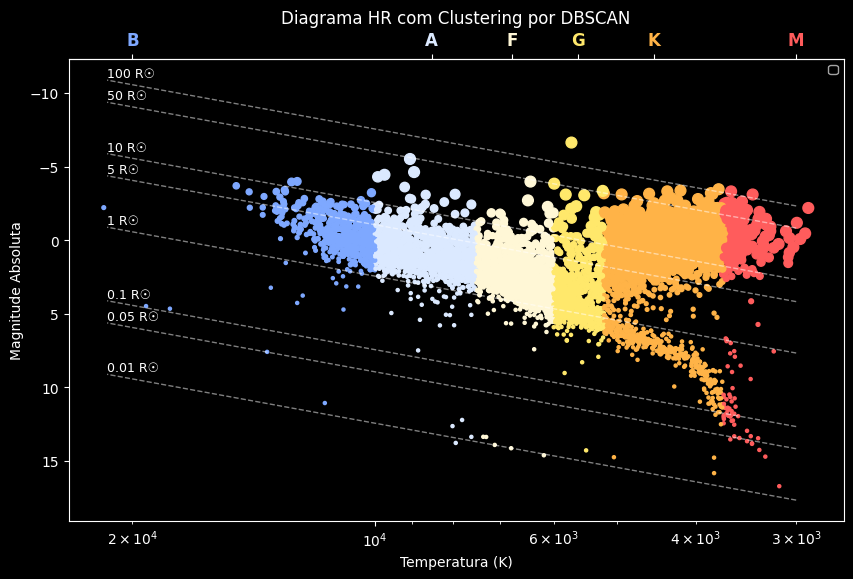

In [154]:
plt.style.use("dark_background")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=dfp["cor_espectral"])

T_sun = 5777
M_sun = 4.83

# intervalo de temperatura do seu gráfico
T_vals = np.logspace(np.log10(3000), np.log10(21500), 500)

raios = [0.01, 0.05, 0.1, 1, 5, 10, 50, 100]

for R in raios:
    M_vals = (
        M_sun
        - 5*np.log10(R)
        - 10*np.log10(T_vals / T_sun)
    )

    ax.plot(T_vals, M_vals, linestyle="--", linewidth=1, color="white", alpha=0.5)

    # rótulo perto da borda direita
    ax.text(
        T_vals[-1],
        M_vals[-1],
        f"{R} R☉",
        fontsize=9,
        verticalalignment='bottom'
    )

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log") # Eixo x na escala log para melhor visualização

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

# eixo superior
ax_top = ax.secondary_xaxis('top')

ticks_temp = [40000, 20000, 8500, 6750, 5600, 4500, 3000]
labels = ["O", "B", "A", "F", "G", "K", "M"]

ax_top.set_xticks(ticks_temp)
ax_top.set_xticklabels(labels)

# colorir os rótulos
for tick, label in zip(ax_top.get_xticklabels(), labels):
    tick.set_color(cores_espectrais[label])
    tick.set_fontsize(12)
    tick.set_fontweight("bold")

ax_top.tick_params(which='minor', top=False)
ax_top.minorticks_off()

plt.title(f"Diagrama HR com Clustering por DBSCAN")
plt.legend(markerscale=1, fontsize="small", loc="best")

plt.show()